# I will use the following notebook to demonstrate different steps in preprocessing

## These steps will include:

### 1) Slice timing correction
### 2) Motion correction

In [1]:
import os
from glob import glob

# Import new things that we'll need
import pandas as pd
import numpy as np
import nipype.interfaces.afni as afni
import nipype.interfaces.fsl as fsl
import nipype.interfaces.freesurfer as fs
from nipype.interfaces.utility import Function
import seaborn as sns
import nibabel as nb
import json
import nipype.interfaces.io as nio
import nipype.pipeline.engine as pe 
import matplotlib.pyplot as plt

%matplotlib inline

### I next want to get a list of all of my functional files

In [2]:
sid = ['021']
base_dir = '/home/nmatt015/Mattfeld_PSB6351/'
work_dir = '/scratch/madlab/Mattfeld_PSB6351/nmatt015/'
func_dir = os.path.join(base_dir, f'dset/sub-{sid[0]}/func')
fmap_dir = os.path.join(base_dir, f'dset/sub-{sid[0]}/fmap')
fs_dir = os.path.join(base_dir, 'derivatives', 'freesurfer')

# Get a list of my study task json and nifti converted files
func_json = sorted(glob(func_dir + '/*.json'))
func_files = sorted(glob(func_dir + '/*.nii.gz'))
fmap_files = sorted(glob(fmap_dir + '/*func*.nii.gz'))

In [3]:
func_files[0]

'/home/nmatt015/Mattfeld_PSB6351/dset/sub-021/func/sub-021_task-loc_run-1_bold.nii.gz'

In [4]:
func_dir

'/home/nmatt015/Mattfeld_PSB6351/dset/sub-021/func'

### Next I want to build and run function to perform slice timing correction. I'm going to have to extract some important information from the .json files like the multiband slicetiming.

In [5]:
os.environ['PATH'] += ':/home/applications/fsl/6.0.6/bin'
!which fslroi

/home/applications/fsl/6.0.6/bin/fslroi


In [6]:
ls /home/nmatt015/Mattfeld_PSB6351/dset/sub-021/anat

sub-021_run-1_T1w.json    sub-021_run-2_T1w.json
sub-021_run-1_T1w.nii.gz  sub-021_run-2_T1w.nii.gz


In [10]:
# Here I am building a function that eliminates the
# mapnode directory structure and assists in saving
# all of the outputs into a single directory
def get_subs(func_files):
    '''Produces Name Substitutions for Each Contrast'''
    subs = []
    for curr_run in range(len(func_files)):
        subs.append(('_tshifter%d' %curr_run, ''))
        subs.append(('_volreg%d' %curr_run, ''))
    return subs

# Here I am building a function that takes in a
# text file that includes the number of outliers
# at each volume and then finds which volume (e.g., index)
# has the minimum number of outliers (e.g., min) 
# searching over the first 201 volumes
# If the index function returns a list because there were
# multiple volumes with the same outlier count, pick the first one

# HW3 - change the search window. how does this impact your results?
def best_vol(outlier_count):
    best_vol_num = outlier_count.index(min(outlier_count[:200]))
    if isinstance(best_vol_num, list):
        best_vol_num = best_vol_num[0]
    return best_vol_num

# Here I am creating a list of lists containing the slice timing for each study run
####################################
# HW3 - what column do you query to extract the appropriate information?
####################################
slice_timing_list = []
for curr_json in func_json:
    curr_json_data = open(curr_json)
    curr_func_metadata = json.load(curr_json_data)
    slice_timing_list.append(curr_func_metadata['SliceTiming'])

# Here I am establishing a nipype work flow that I will eventually execute
psb6351_wf = pe.Workflow(name='psb6351_wf')
psb6351_wf.base_dir = work_dir + f'/psb6351workdir/sub-{sid[0]}'
psb6351_wf.config['execution']['use_relative_paths'] = True

# Create a Function node to substitute names of files created during pipeline
getsubs = pe.Node(Function(input_names=['func_files'],
                           output_names=['subs'],
                           function=get_subs),
                  name='getsubs')
getsubs.inputs.func_files = func_files

# Here I am inputing just the first run functional data
# I want to use afni's 3dToutcount to find the number of 
# outliers at each volume.  I will use this information to
# later select the earliest volume with the least number of outliers
# to serve as the base for the motion correction
id_outliers = pe.Node(afni.OutlierCount(),
                      name = 'id_outliers')
####################################
# HW3 - what happens if you chose a different func_file?  How does it impact results
# Is the first func file the best way to go?
####################################
id_outliers.inputs.in_file = func_files[0]
id_outliers.inputs.automask = True
id_outliers.inputs.out_file = 'outlier_file'

# Create a Function node to identify the best volume based
# on the number of outliers at each volume. I'm searching
# for the index in the first 201 volumes that has the 
# minimum number of outliers and will use the min() function
# I will use the index function to get the best vol. 
getbestvol = pe.Node(Function(input_names=['outlier_count'],
                              output_names=['best_vol_num'],
                              function=best_vol),
                     name='getbestvol')
psb6351_wf.connect(id_outliers, 'out_file', getbestvol, 'outlier_count')

# Extract the earliest volume with the
# the fewest outliers of the first run as the reference 
extractref = pe.Node(fsl.ExtractROI(t_size=1),
                     name = "extractref")
####################################
# HW3 - if you choose a different func file...should this change too?
# If yes, why?  what should it change to?
####################################
extractref.inputs.in_file = func_files[0]
psb6351_wf.connect(getbestvol, 'best_vol_num', extractref, 't_min')

# Below is the command that runs AFNI's 3dvolreg command.
# this is the node that performs the motion correction
# I'm iterating over the functional files which I am passing
# functional data from the slice timing correction node before
# I'm using the earliest volume with the least number of outliers
# during the first run as the base file to register to.

####################################
# HW3 - what happens when you change the order of the following two nodes?
# How does that impact your results?
# Run things again with the order reversed and save in a new sink folder without deleting your first
####################################
volreg1st = pe.MapNode(afni.Volreg(),
                    iterfield=['in_file'],
                    name = 'volreg1st')
volreg1st.inputs.outputtype = 'NIFTI_GZ'
volreg1st.inputs.zpad = 4
volreg1st.inputs.in_file = func_files
psb6351_wf.connect(extractref, 'roi_file', volreg1st, 'basefile')

mcflirt1st = pe.MapNode(fsl.MCFLIRT(),
                    iterfield=['in_file'],
                    name = 'mcflirt1st')
mcflirt1st.inputs.output_type = 'NIFTI_GZ'
mcflirt1st.inputs.in_file = func_files
psb6351_wf.connect(extractref, 'roi_file', mcflirt1st, 'ref_file')

# Below is the command that runs AFNI's 3dTshift command
# this is the node that performs the slice timing correction
# I input the study func files as a list and the slice timing 
# as a list of lists. I'm using a MapNode to iterate over the two.
# this should allow me to parallelize this on the HPC
tshifter2nd = pe.MapNode(afni.TShift(),
                      iterfield=['in_file','slice_timing'],
                      name = 'tshifter2nd')
tshifter2nd.inputs.tr = '1.76'
tshifter2nd.inputs.slice_timing = slice_timing_list
tshifter2nd.inputs.outputtype = 'NIFTI_GZ'
psb6351_wf.connect(volreg1st, 'out_file', tshifter2nd, 'in_file')

tshifter1st = pe.MapNode(afni.TShift(),
                      iterfield=['in_file','slice_timing'],
                      name = 'tshifter1st')
tshifter1st.inputs.tr = '1.76'
tshifter1st.inputs.slice_timing = slice_timing_list
tshifter1st.inputs.outputtype = 'NIFTI_GZ'
tshifter1st.inputs.in_file = func_files

volreg2nd = pe.MapNode(afni.Volreg(),
                    iterfield=['in_file'],
                    name = 'volreg2nd')
volreg2nd.inputs.outputtype = 'NIFTI_GZ'
volreg2nd.inputs.zpad = 4
psb6351_wf.connect(extractref, 'roi_file', volreg2nd, 'basefile')
psb6351_wf.connect(tshifter1st, 'out_file', volreg2nd, 'in_file')

# HW4 Add a coregistration node to coregister functional to structural
# make sure to connect node appropriately and to sink the data
# in the datasink below appropriately...required...sink the transformation matrix

coregister = pe.MapNode(fsl.FLIRT(),
                        iterfield=['in_file'], 
                        name='coregister')
coregister.inputs.output_type = 'NIFTI_GZ'
coregister.inputs.dof = 6

coregister.inputs.reference = '/home/nmatt015/Mattfeld_PSB6351/dset/sub-021/anat/sub-021_run-1_T1w.nii.gz'

# Below is the node that collects all the data and saves
# the outputs that I am interested in. Here in this node
# I use the substitutions input combined with the earlier
# function to get rid of nesting
datasink = pe.Node(nio.DataSink(), name="datasink")
datasink.inputs.base_directory = os.path.join(base_dir, 'derivatives/preproc')
datasink.inputs.container = f'sub-{sid[0]}'
psb6351_wf.connect(tshifter2nd, 'out_file', datasink, 'sltime_corr2nd')
psb6351_wf.connect(extractref, 'roi_file', datasink, 'study_ref')
psb6351_wf.connect(volreg1st, 'out_file', datasink, 'motion1stAFNI.@corrfile')
psb6351_wf.connect(volreg1st, 'oned_matrix_save', datasink, 'motion1stAFNI.@matrix')
psb6351_wf.connect(volreg1st, 'oned_file', datasink, 'motion1stAFNI.@par')
psb6351_wf.connect(getsubs, 'subs', datasink, 'substitutions')

psb6351_wf.connect(mcflirt1st, 'mat_file', datasink, 'motion1stFSL.@matrix')
psb6351_wf.connect(mcflirt1st, 'par_file', datasink, 'motion1stFSL.@par')
psb6351_wf.connect(mcflirt1st, 'out_file', datasink, 'motion1stFSL.@corrfile')

psb6351_wf.connect(tshifter1st, 'out_file', datasink, 'sltime_corr1st')
psb6351_wf.connect(volreg2nd, 'out_file', datasink, 'motionn2nd.@corrfile')
psb6351_wf.connect(volreg2nd, 'oned_matrix_save', datasink, 'motion2nd.@matrix')
psb6351_wf.connect(volreg2nd, 'oned_file', datasink, 'motion2nd.@par')

psb6351_wf.connect(volreg1st, 'out_file', coregister, 'in_file')
psb6351_wf.connect(coregister, 'out_file', datasink, 'coregistration.@registered_func')
psb6351_wf.connect(coregister, 'out_matrix_file', datasink, 'coregistration.@transform_matrix')

# The following lines set a work directory outside of my 
# local git repo and runs the workflow
psb6351_wf.run()
#psb6351_wf.run(plugin='SLURM',
#               plugin_args={'sbatch_args': ('--partition IB_44C_512G --qos pq_madlab --account acc_madlab'),
#                            'overwrite':True})

241017-17:07:16,194 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
241017-17:07:16,204 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
241017-17:07:16,221 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
241017-17:07:16,246 nipype.workflow INFO:
	 Workflow psb6351_wf settings: ['check', 'execution', 'logging', 'monitoring']
241017-17:07:16,334 nipype.workflow INFO:
	 Running serially.
241017-17:07:16,335 nipype.workflow INFO:
	 [Node] Setting-up "psb6351_wf.id_outliers" in "/scratch/madlab/Mattfeld_PSB6351/nmatt015/psb6351workdir/sub-021/psb6351_wf/id_outliers".
241017-17:07:16,353 nipype.workflow INFO:
	 [Node] Cached "psb6351_wf.id_outliers" - collecting precomputed outputs
241017-17:07:16,354 nipype.workflow INFO:
	 [Node] "psb6351_wf.id_outliers" found cached.
241017-17:07:16,370 nipype.workflow INFO:
	 [Node] "psb6351_

### Now I will load and plot the motion files

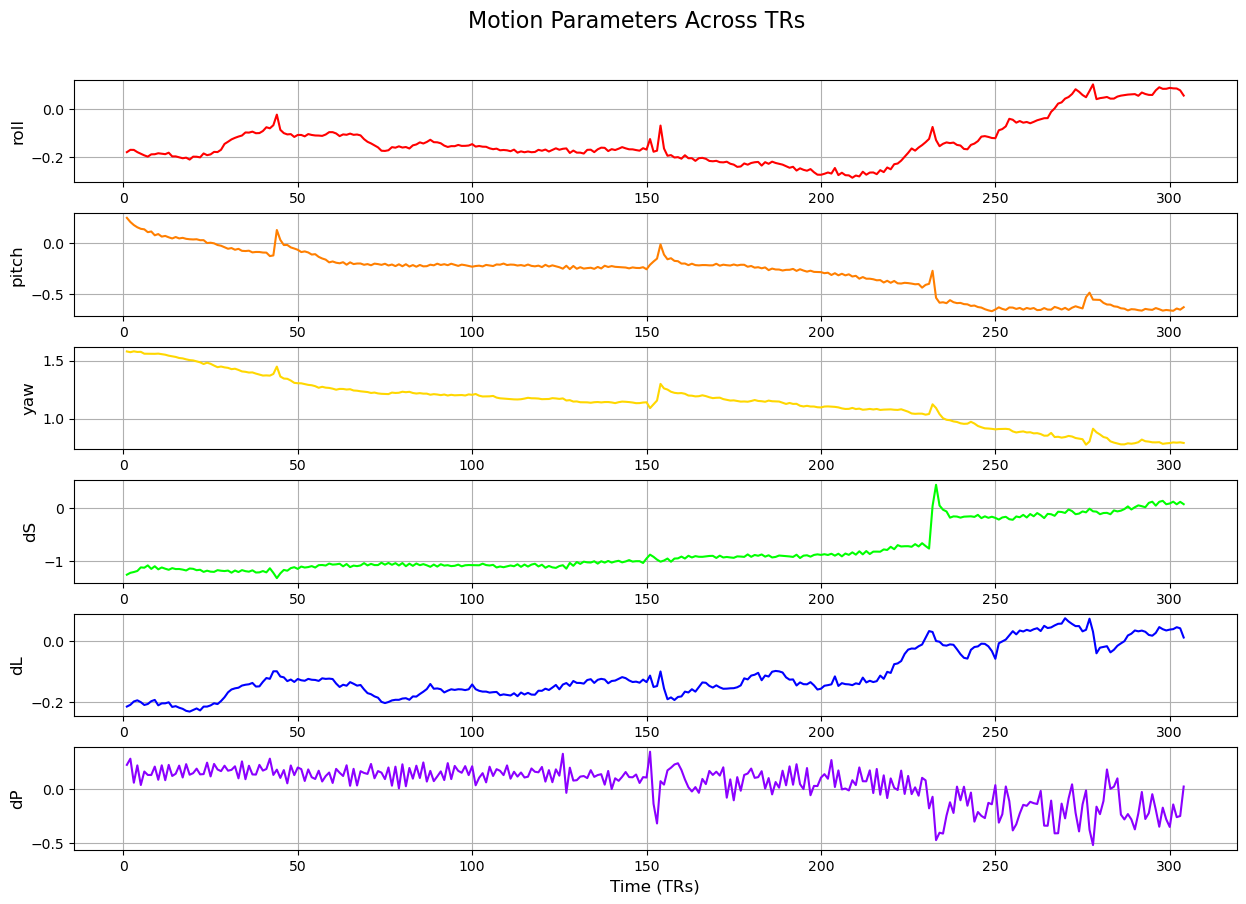

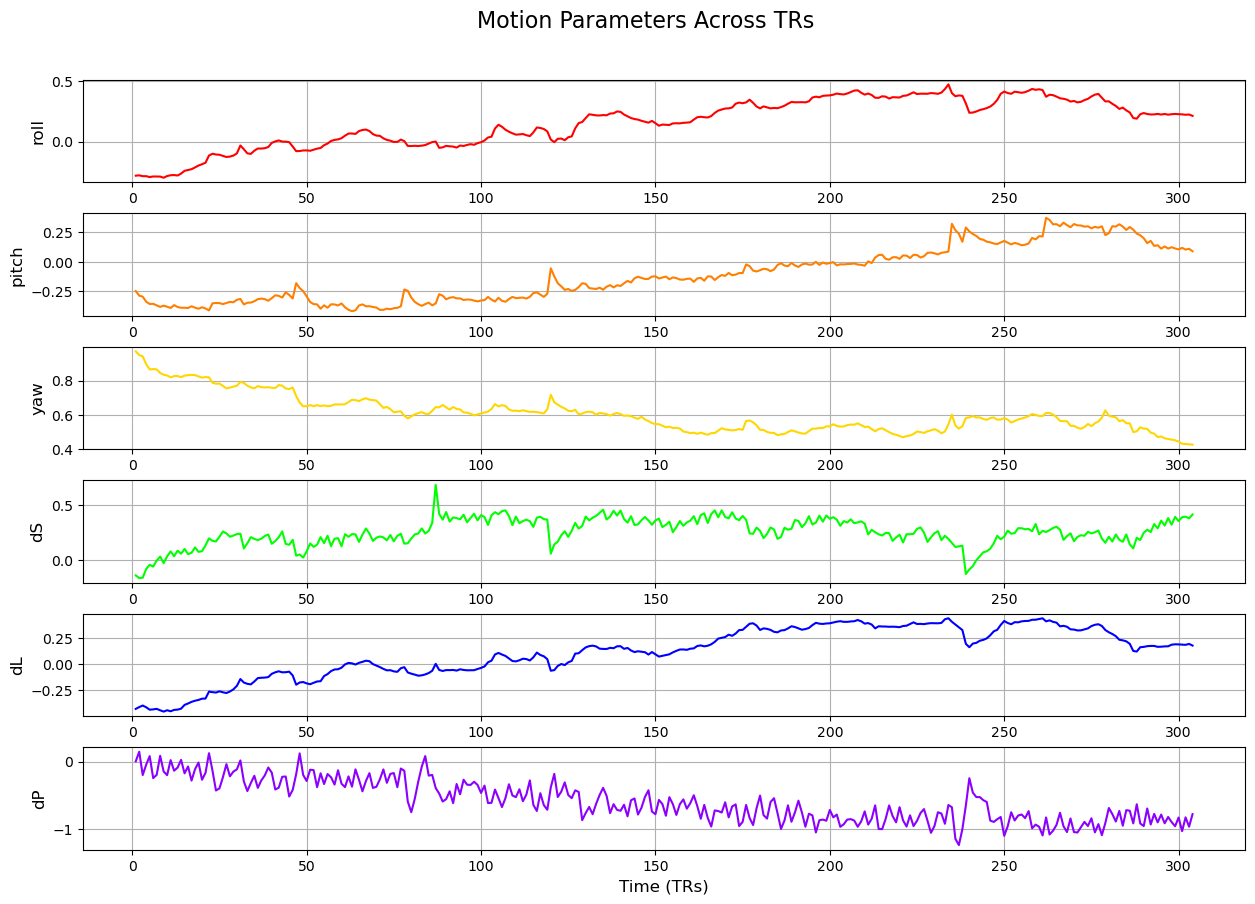

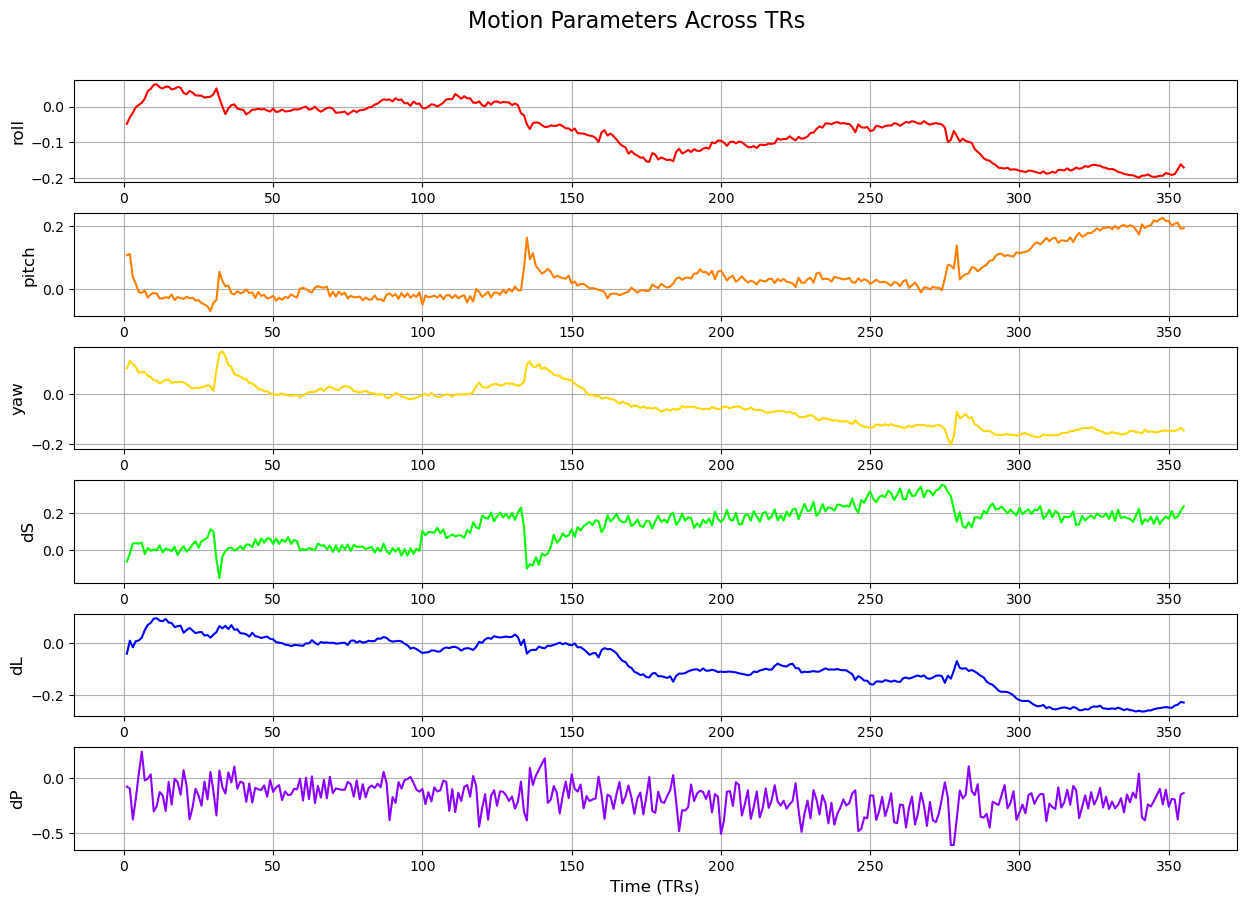

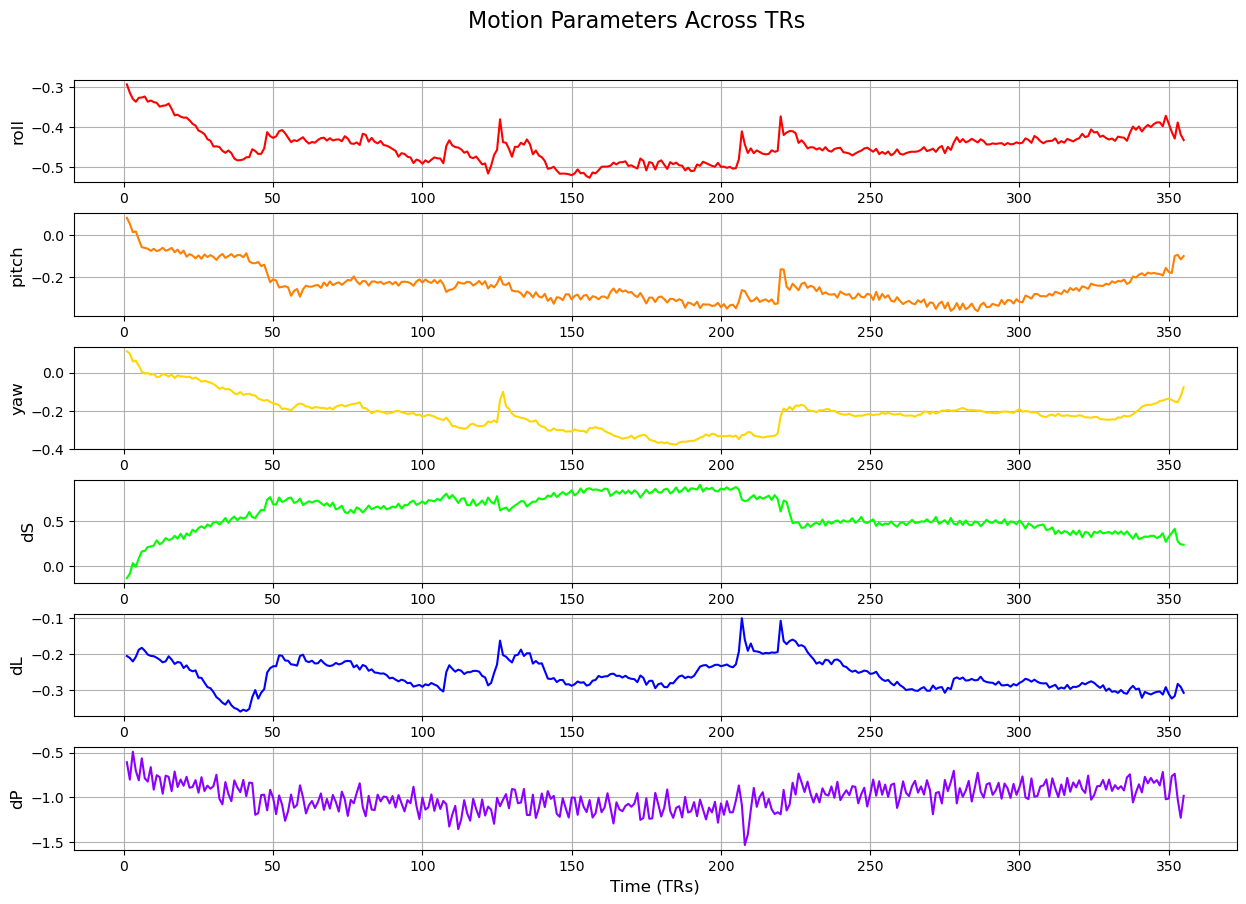

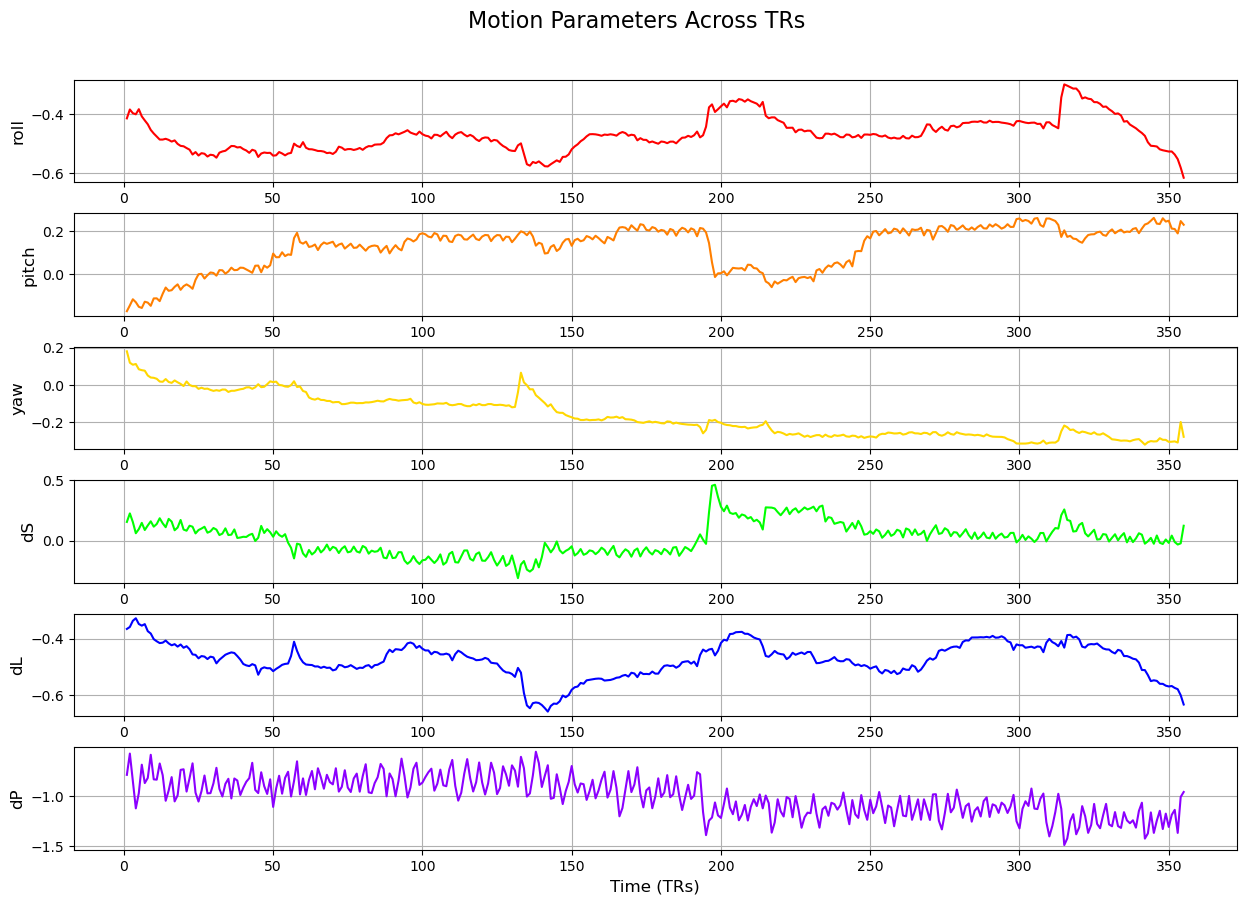

In [11]:
motion_dir = os.path.join(base_dir, f'derivatives/preproc/sub-{sid[0]}/motion')
study_motion_files = sorted(glob(motion_dir + '/*_bold.1D'))

for curr_mot_file in study_motion_files:
    # Read the motion parameters into a dataframe
    motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None, engine='python')
    motion_df.columns = ['roll', 'pitch', 'yaw', 'dS', 'dL', 'dP']
    # Roll- rotation around the x axis
    # Pitch- rotation around the y axis
    # Yaw- rotation around the z axis
    # dS = displacement along superior inferior axis
    # dS- translation along the z axis
    # dL = displacement along the left right axis
    # dL- translation along the x axis
    # dP = displacement along the anterior posterior axis
    # dP- translation along the y axis

    # Prepare the figure and axes for plotting
    num_vols = range(1, len(motion_df) + 1)
    fig, axs = plt.subplots(motion_df.shape[1], 1, figsize=(15, 10))
    fig.subplots_adjust(hspace=0.3)  # Reduce space between plots

    # Change the colors so each parameter is unique
    colors = ['#FF0000', '#FF7F00', '#FFD700', '#00FF00', '#0000FF', '#8B00FF'] 

    # Plot each motion parameter
    for idx, (curr_col, color) in enumerate(zip(motion_df.columns, colors)):
        axs[idx].plot(num_vols, motion_df[curr_col], color=color, linewidth=1.5)
        axs[idx].set_ylabel(f'{curr_col}', fontsize=12)
        axs[idx].grid(True)

    # Set the x-axis label for the last subplot only, reads a bit easier 
    axs[-1].set_xlabel('Time (TRs)', fontsize=12)

    # Add a title for the entire figure
    fig.suptitle('Motion Parameters Across TRs', fontsize=16, y=0.95)

    # Display the plot
    plt.show()

####################################
# HW3 - compare the motion parameter plots from this script to 
# the carpet plot below.  What is the relationship between large rotations and/or translations and the carpet plot
# reference specific TRs and their relation to time.
####################################

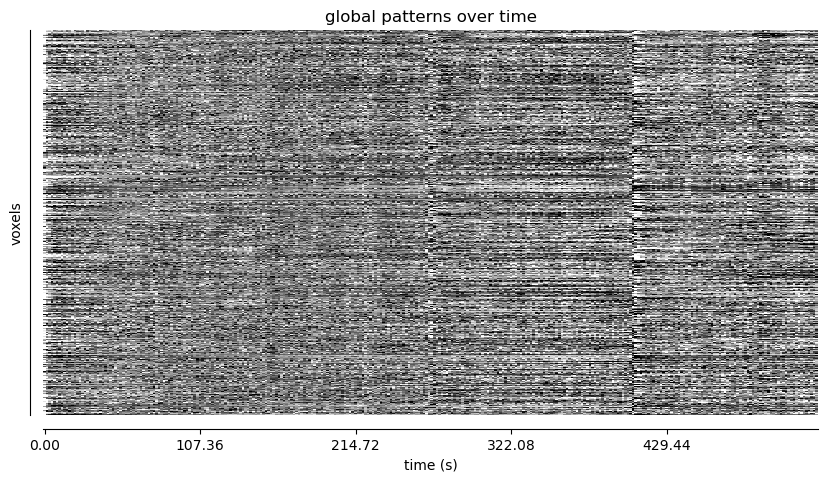

In [13]:
from nilearn.plotting import plot_carpet

from nilearn import masking

# Build an EPI-based mask because we have no anatomical data

####################################
# HW3 - compare different func files and their carpet plots
# which one are we looking at here? Which func file has the 
# most visually striking motion related changes in voxel intensity?
####################################

mask_img = masking.compute_epi_mask(func_files[0])

display = plot_carpet(
    func_files[0],
    mask_img,
    t_r=1.76,
    standardize="zscore_sample",
    title="global patterns over time",
)

display.show()